In [1]:
import requests
import bs4
import urllib.request
import os.path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import scipy.stats as st
import datetime

np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Downloading data

In [3]:
# base_url = 'http://iew3.technion.ac.il/serveng/callcenterdata/'
# page = bs4.BeautifulSoup(requests.get(base_url).text)

In [4]:
# for i in page.find_all('a'):
#     if 'ZIP' in i['href']:
#         if not os.path.exists(i['href']):
#             print(i)
#             urllib.request.urlretrieve(base_url + i['href'], i['href'])

# Data Analysis

In [5]:
dfs = {i: pd.read_csv(i, sep='\s+') for i in sorted(glob.glob('*ZIP'))}

In [6]:
tss = {i: pd.to_datetime(dfs[i].date.astype(str) + dfs[i].vru_entry, format='%y%m%d%H:%M:%S') for i in dfs}

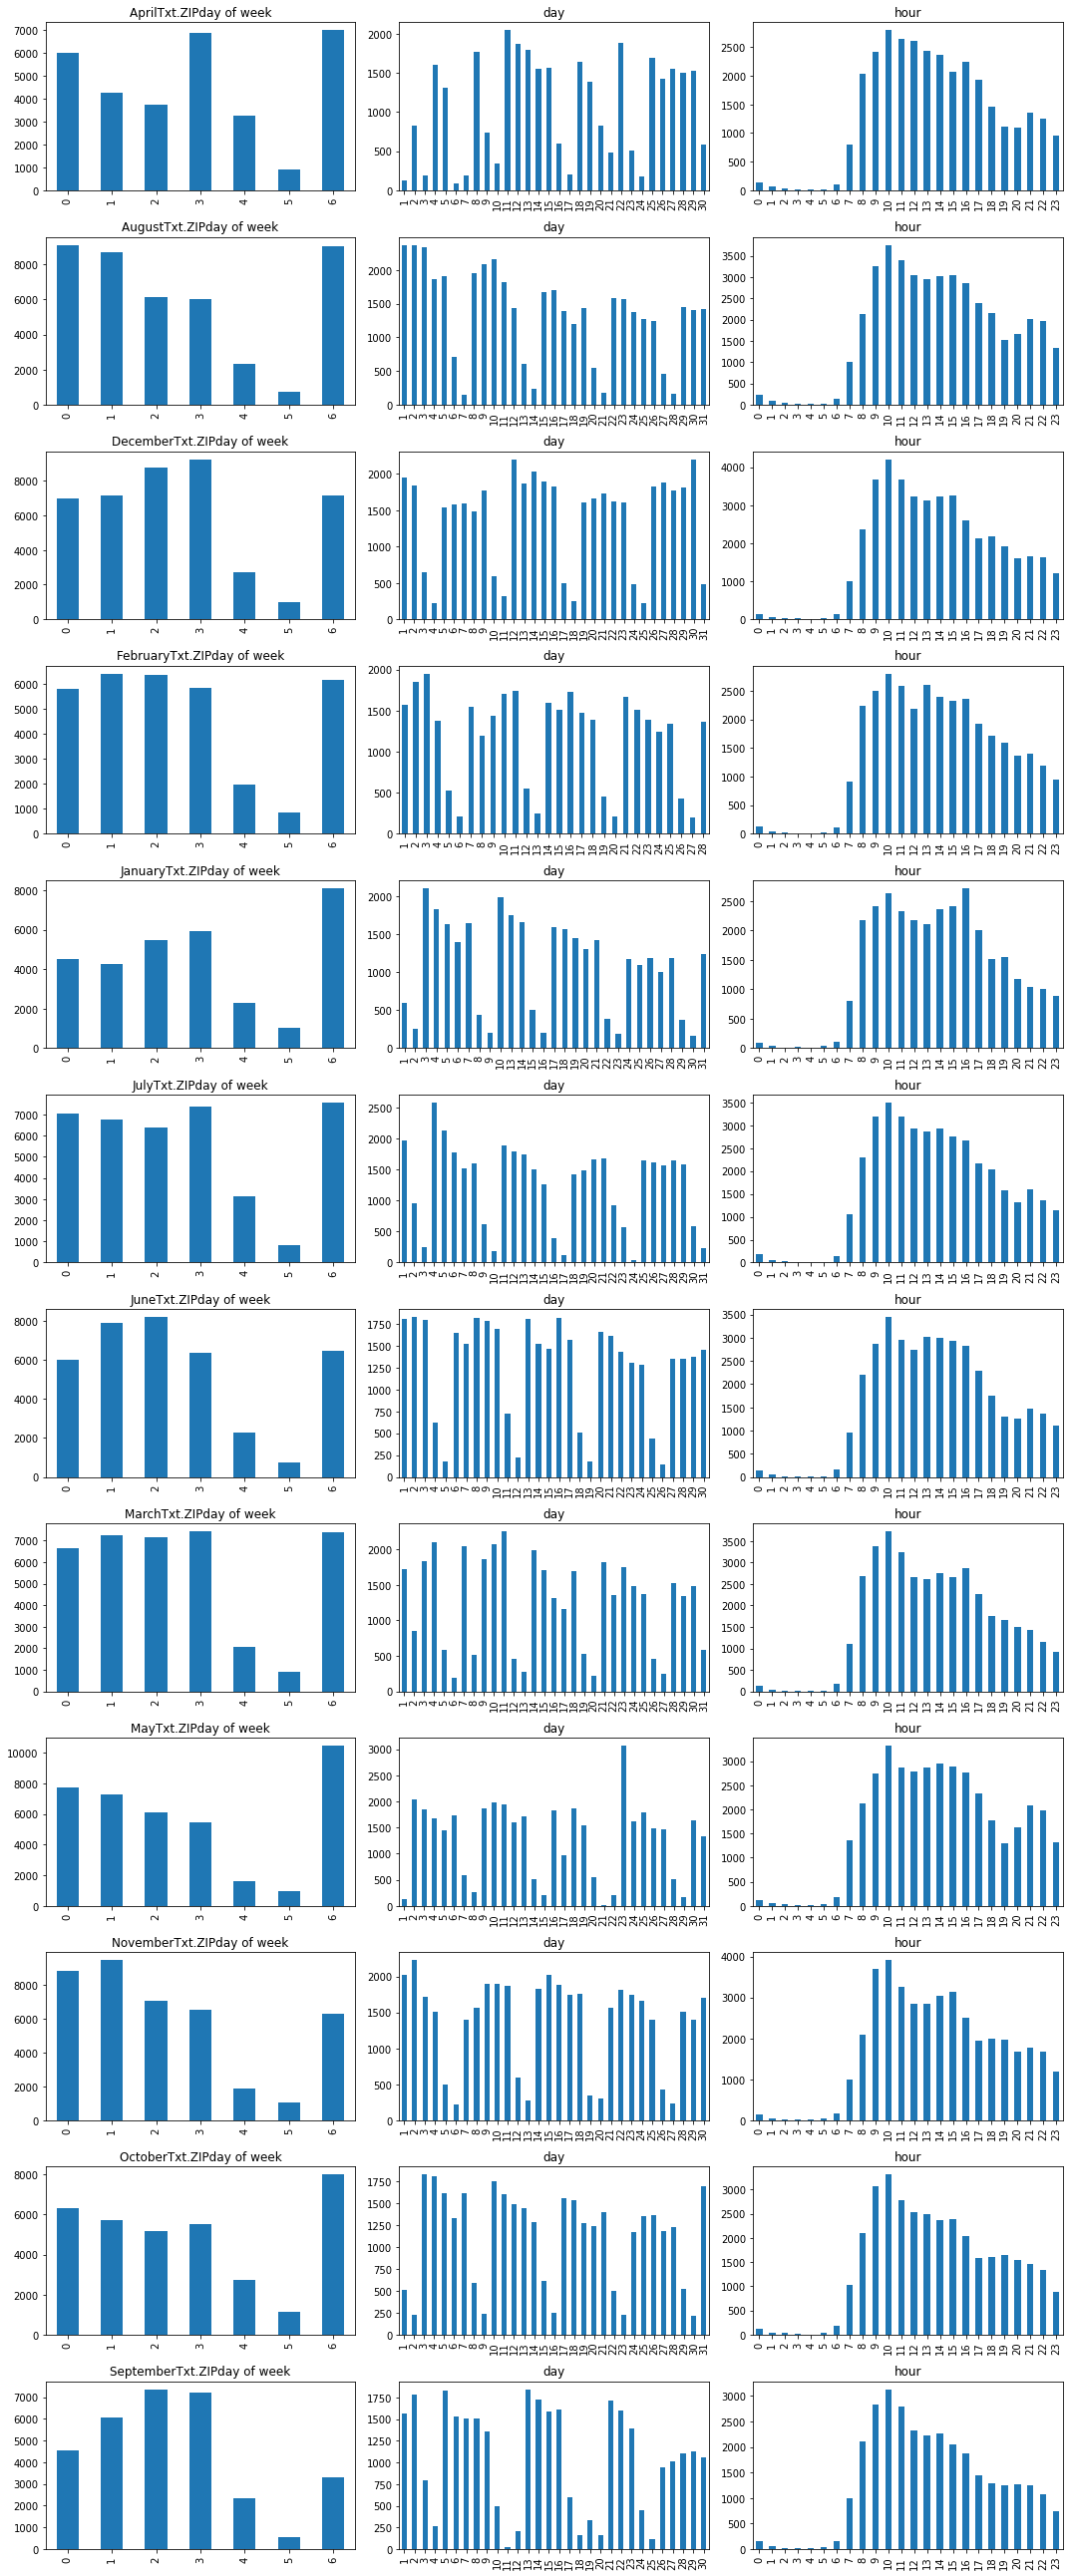

In [7]:
plt.figure(figsize=np.array((15,len(tss)*3)))
for i, k in enumerate(tss):
    plt.subplot(len(tss), 3, 3*i+1)
    tss[k].groupby(tss[k].dt.dayofweek).count().plot.bar(title=k + 'day of week')
    
    plt.subplot(len(tss), 3, 3*i+2)
    tss[k].groupby(tss[k].dt.day).count().plot.bar(title = 'day')
    
    plt.subplot(len(tss), 3, 3*i+3)
    tss[k].groupby(tss[k].dt.hour).count().plot.bar(title = 'hour')

plt.tight_layout()

In [8]:
ts_all = pd.concat(tss.values()).sort_values()

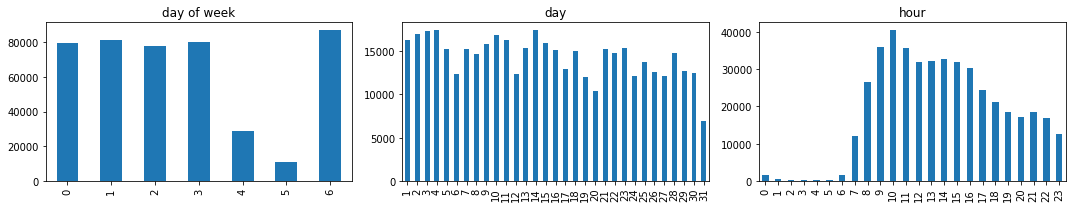

In [9]:
plt.figure(figsize=np.array((15,3)))

plt.subplot(1, 3, 1)
ts_all.groupby(ts_all.dt.dayofweek).count().plot.bar(title='day of week')

plt.subplot(1, 3, 2)
ts_all.groupby(ts_all.dt.day).count().plot.bar(title = 'day')

plt.subplot(1, 3, 3)
ts_all.groupby(ts_all.dt.hour).count().plot.bar(title = 'hour')

plt.tight_layout()

# Goodness-of-fit testing

In [10]:
def ks_fit(smp):
    dif_all = (smp[1:].values - smp[:-1].values).astype(int)//10**9
    expon_params = st.expon.fit(dif_all)
    expon_fitted = st.expon(*expon_params)
    return len(smp), expon_fitted, st.ks_1samp(dif_all, expon_fitted.cdf)

In [11]:
ks_fit(ts_all)

(444448,
 KstestResult(statistic=0.23644265968954337, pvalue=0.0))

In [12]:
%%time 
np.mean([ks_fit(i[1])[2].pvalue > .05 for i in ts_all.groupby([ts_all.dt.month, ts_all.dt.day, ts_all.dt.hour]) if len(i[1]) >= 4])

CPU times: user 9.43 s, sys: 10.6 ms, total: 9.44 s
Wall time: 9.44 s


0.9764705882352941

In [13]:
smp = ts_all[(ts_all.dt.day == 1) & (ts_all.dt.month == 1) & (ts_all.dt.hour == 0)]
expon_fitted = ks_fit(smp)[1]

isfit = refit = 0

for i in ts_all.groupby([ts_all.dt.month, ts_all.dt.day, ts_all.dt.hour]):
    if len(i[1]) < 4:
        continue
    
    smp = i[1]
    dif_all = (smp[1:].values - smp[:-1].values).astype(int)//10**9
    
    try:
        ksr = st.ks_1samp(dif_all, expon_fitted.cdf)
    except:
        ksr = st.ks_1samp(dif_all, expon_fitted.cdf, mode='approx')
        
    if ksr.pvalue < 0.01:
        expon_fitted = st.expon(*st.expon.fit(dif_all))

        refit += 1
    else:
        isfit += 1
        
isfit, refit

(3615, 1995)

In [14]:
%%time

expon_fitted = lim_inf = None

isfit = refit = 0

for i in ts_all.groupby([ts_all.dt.year, ts_all.dt.month, ts_all.dt.day, ts_all.dt.hour]):
    if lim_inf == None:
        lim_inf = datetime.datetime(*i[0])
        
    lim_sup = datetime.datetime(*i[0])
    smp = ts_all[(lim_inf <= ts_all) & (ts_all < lim_sup + datetime.timedelta(hours=1))]
    
    if len(smp) > 3:
        dif_all = (smp[1:].values - smp[:-1].values).astype(int)//10**9
        
        if expon_fitted == None:
            
            expon_fitted = st.expon(*st.expon.fit(dif_all))
            refit += 1
        elif st.ks_1samp(dif_all, expon_fitted.cdf).pvalue < 0.01:
            #print(lim_inf, lim_sup)
            expon_fitted = None
            lim_inf = lim_sup
        else:
            isfit += 1
            
    if isfit + refit > 10**5:
        break
        
isfit, refit

CPU times: user 23.6 s, sys: 11.4 ms, total: 23.7 s
Wall time: 23.7 s


(4479, 1259)

In [27]:
expon_fitted = None

isfit = refit = lim_inf = 0

for i, e in enumerate(ts_all):
    
    smp = ts_all[lim_inf:i]

    if len(smp) > 3:
        dif_all = (smp[1:] - smp[:-1]).astype(int)//10**9
   
        if expon_fitted == None:
            expon_fitted = st.expon(*st.expon.fit(dif_all))
            refit += 1
        elif st.ks_1samp(dif_all, expon_fitted.cdf).pvalue < 0.01:
            expon_fitted = None
            lim_inf = i
            # zerar amostra, colocar um bloco de hora
        else:
            isfit += 1
    
    if isfit + refit > 10**3: # 10**5
        break
        
isfit, refit

(667, 334)

In [16]:
import jcs_paper_util as util

In [28]:
util.eval_eda(ts_all, 10)

TypeError: unsupported operand type(s) for -: 'Timestamp' and 'float'

In [39]:
ts_all[0]

0   1999-01-01 00:00:31
0   1999-02-01 07:02:47
0   1999-03-01 00:14:46
0   1999-04-01 20:06:04
0   1999-05-01 22:07:01
0   1999-06-01 06:14:17
0   1999-07-01 00:26:17
0   1999-08-01 01:10:39
0   1999-09-01 00:02:41
0   1999-10-01 00:24:58
0   1999-11-01 06:31:36
0   1999-12-01 05:20:04
dtype: datetime64[ns]